# Stock Index prediction

Stock price movement is driven by fundamental and technical analysis.  In this project we aim to predict the prices using technical analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (20,10)

5 Year historical S&P500 prices downloaded from www.yahoo.com.

In [2]:
#Read the file
spx = pd.read_csv('spx.csv')
spx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-07,1770.739990,1774.540039,1746.199951,1747.150024,1747.150024,4143200000
1,2013-11-08,1748.369995,1770.780029,1747.630005,1770.609985,1770.609985,3837170000
2,2013-11-11,1769.959961,1773.439941,1767.849976,1771.890015,1771.890015,2534060000
3,2013-11-12,1769.510010,1771.780029,1762.290039,1767.689941,1767.689941,3221030000
4,2013-11-13,1764.369995,1782.000000,1760.640015,1782.000000,1782.000000,3327480000


* Columns *Open* and *Close* are the starting and ending prices of the day
* Columns *High* and *Low* are the highest and lowest prices of the day
* Column *Volume* is the total number of shares traded (that belonged to the S&P500 index)
* Column *Adj Close* is the adjusted closing price of the day.  It is usually same as the closing price of the day. 

In [3]:
# Let's make sure Close and Adj Close columns are same
(spx['Close'] == spx['Adj Close']).sum() == spx.shape[0]

True

In [4]:
# Adj Close column can be dropped
spx.drop('Adj Close', axis=1, inplace=True)

In [5]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
Date      1259 non-null object
Open      1259 non-null float64
High      1259 non-null float64
Low       1259 non-null float64
Close     1259 non-null float64
Volume    1259 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [6]:
# The column *Date* is in 'Object' format.  
# It needs to be changed to DateTime format

spx['Date'] = pd.to_datetime(spx['Date'], format='%Y-%m-%d')

#  Date is also set as index
spx.index = spx['Date']

In [7]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-11-07 to 2018-11-06
Data columns (total 6 columns):
Date      1259 non-null datetime64[ns]
Open      1259 non-null float64
High      1259 non-null float64
Low       1259 non-null float64
Close     1259 non-null float64
Volume    1259 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 68.9 KB


**Profit / Loss is determined using the closing price of the stock or index.  Hence we will make *Close* as the target variable**

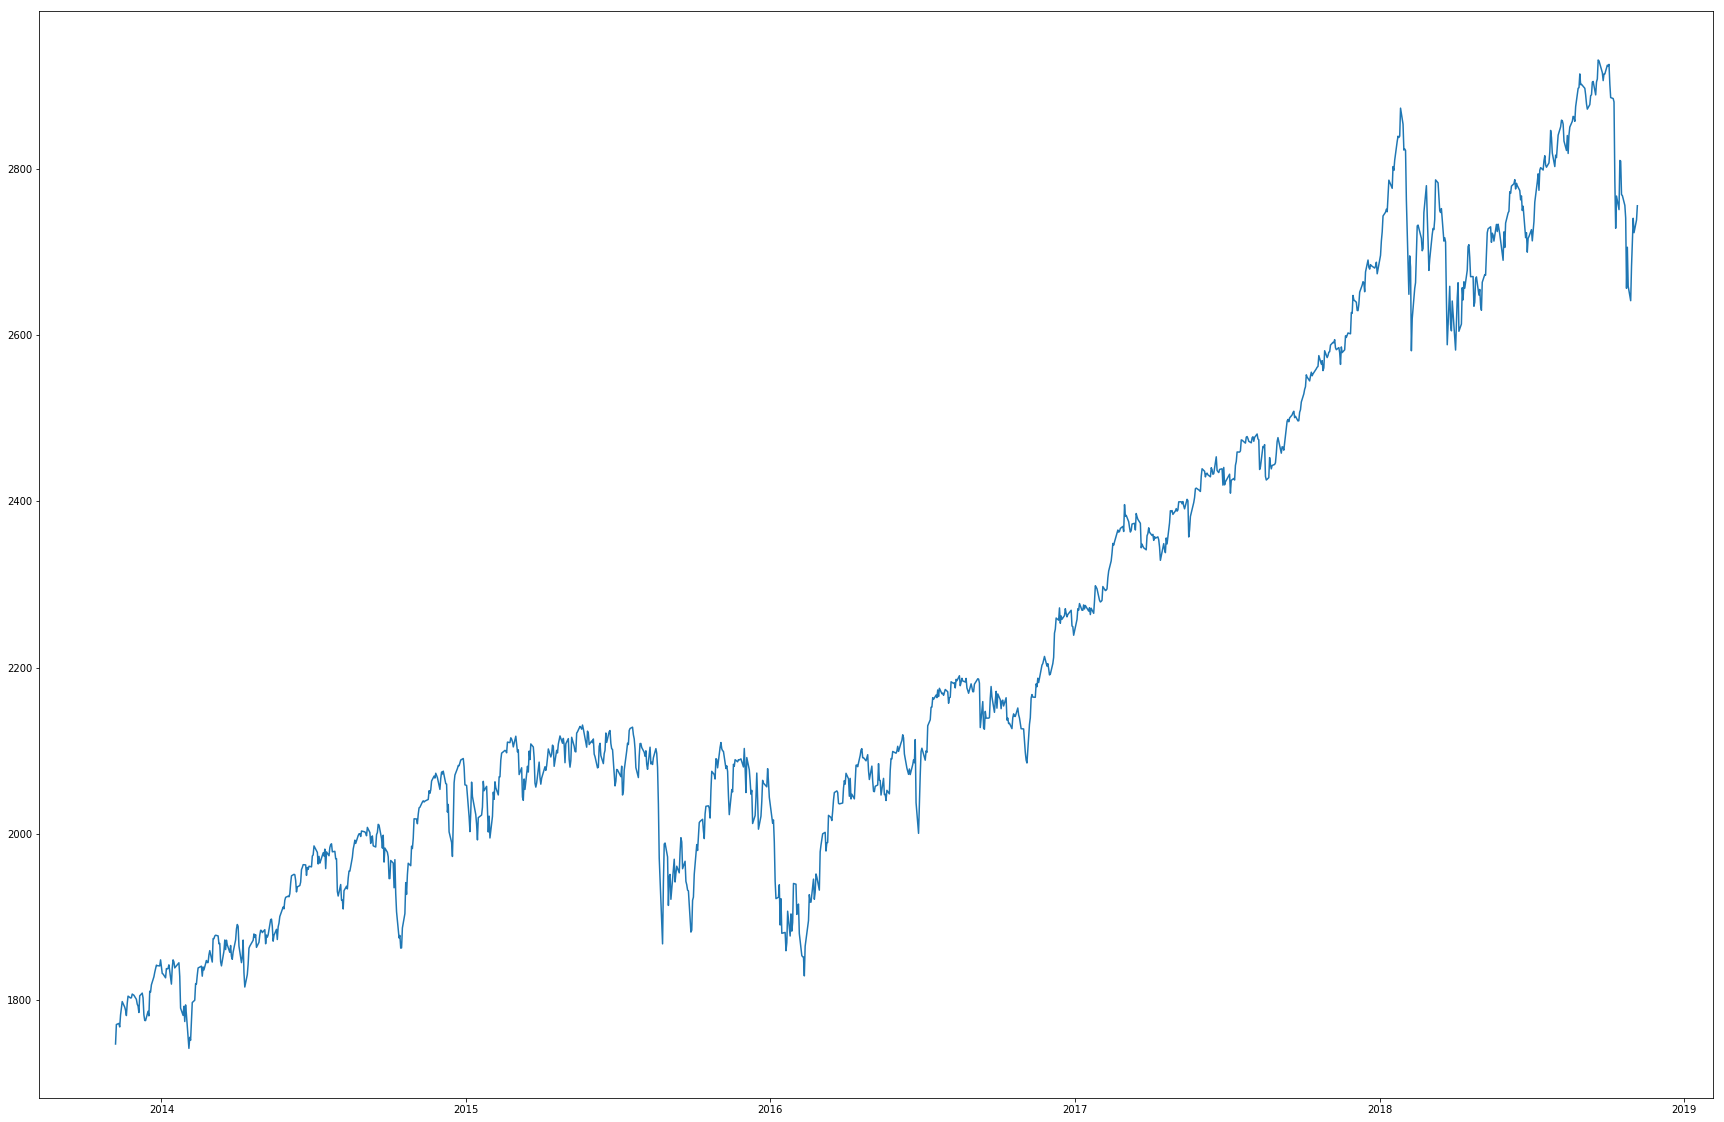

In [8]:
# Arrange the dataset in chronological order
spx = spx.sort_index(ascending=True, axis=0)
# Plot closing price as a function of time
plt.figure(figsize=(30,20))
plt.plot(spx['Close'])
plt.show()

## Moving average
Moving average is a commonly used indicator to predict stock price.  The price is predicted as equal to the average closing prices for previous set of n closing prices.  We will use only the date and close columns and apply moving average predict the stock price.  Typical random splitting as train and test set does not make sense on a time series data.  Hence we will split them as follows:  First 80% rows for training and last 20% for testing.

In [9]:
spx = pd.DataFrame(spx['Close'])

In [10]:
# Splilt into train and test
split_length = int(spx.shape[0] * 0.8)
train = spx.iloc[:split_length]
test = spx.iloc[split_length:]

In [11]:
spx.shape, train.shape, test.shape

((1259, 1), (1007, 1), (252, 1))

In [12]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2013-11-07 00:00:00'),
 Timestamp('2017-11-06 00:00:00'),
 Timestamp('2017-11-07 00:00:00'),
 Timestamp('2018-11-06 00:00:00'))

In [13]:
# Lets make predictions for the 
test['pred']  = spx['Close'].rolling(window=252, center=False).mean().tail(252).values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
#  Let's determine the rmse using the moving average method
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test['Close'], test['pred']) ** 0.5
print(rmse)

185.06954074095864


In [15]:
#  rmse by itself does not give us much insight about model perforrmance
#  Let's plot the predictions vs the closing prices in the test set

In [16]:
# Define a function that plots the train, test and predictions that can be used with other prediction algorithms
def plot_preds(df_train, df_test):
    plt.figure(figsize=(20,10), frameon=False, dpi=100)
    plt.plot(df_train.index,df_train['Close'], color='green', alpha=0.5)
    plt.plot(df_test.index,df_test['Close'], color='blue')
    plt.plot(df_test.index,df_test['pred'], color='red')
    plt.legend(['Train', 'Test', 'Predicted'], fontsize=18)
    plt.grid(which='both')
    plt.show()    
    rmse = np.sqrt(np.mean(np.power((df_test['Close']-df_test['pred']),2)))
    print('RMSE = ' + str(rmse))
    

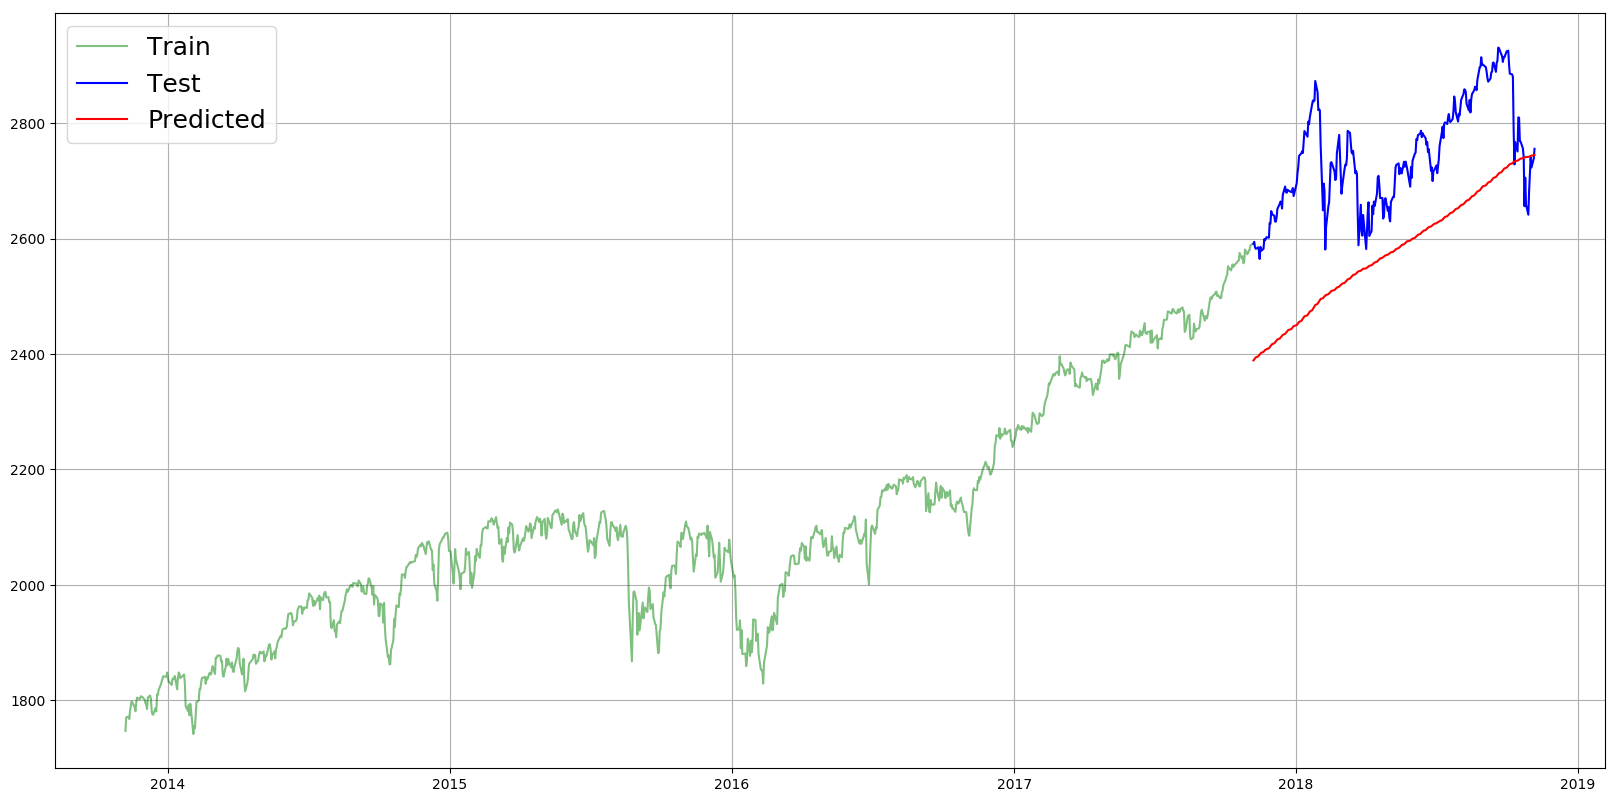

RMSE = 185.06954074095856


In [17]:
plot_preds(train, test)

# Moving average with a window length equal to test size, the results are not very promising

## Linear Regression

Linear Regression is one of the most simplest algorithm that can be implemented right out of the box to create some baseline predictions.  In this case, there is only one feature *Date*.  This can be broken down into several new relevant features like 
* *year*, 
* *month*, 
* *week*, 
* *day*, 
* *dayofweek*,  
* *dayofyear*, 
* *is_month_start*, 
* *is_month_end*, 
* *is_quarter_start*, 
* *is_quarter_end*, 
* *is_option_exp_week*

In [18]:
# Make sure the dates are in ascending order
spx = spx.sort_index(ascending=True)

In [19]:
def get_date_features(df):
    '''
    Takes a dataframe with a Date Index and returns a dataframe with new feature columns
    added: year, month, dayofweek, dayofmonth, dayofyear, is_month_start, 
    is_month_end, is_quarter_start, is_quarter_end, is_option_ex_week
    '''
    df['Date'] = df.index
    df['year'] = df['Date'].apply(lambda x: x.strftime('%Y')).astype('int')
    df['month'] = df['Date'].apply(lambda x: x.strftime('%m')).astype('int')
    df['dayofweek'] = df['Date'].apply(lambda x: x.strftime('%w')).astype('int')
    df['dayofmonth'] = df['Date'].apply(lambda x: x.strftime('%d')).astype('int')
    df['dayofyear'] = df['Date'].apply(lambda x: x.strftime('%j')).astype('int')
    
    # Start of month is defined as first 7 days of month
    df['is_month_start'] = (df['dayofmonth'] <= 7).astype('int')
    
    # End of month is defined as last 7 days of month
    month_dict = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:30, 8:31, 9:30, 10:31, 11:30, 12:31}
    df['is_month_end'] = df[['dayofmonth', 'month']].apply(lambda x: x['dayofmonth'] >= (month_dict[x['month']]-7), axis=1).astype('int')
    
    #Quarter Start is defined as first 7 days of January, April, July and October
    df['is_quarter_start'] = (df['is_month_start'] & ((df['month']==1)|(df['month']==4)|(df['month']==7)|(df['month']==10))).astype('int')
    
    #Quarter end is defined as last 7 days of March, June, September, December
    df['is_quarter_end'] = (df['is_month_end'] & ((df['month']==3)|(df['month']==6)|(df['month']==9)|(df['month']==12))).astype('int')
    
    # Stock options expire third friday of every month.  The week in which third friday appears is called Option Expiration week
    # and this week tends to be volatile.
    df['is_option_ex_week'] = df[['dayofweek', 'dayofmonth']].apply(lambda x: (x['dayofweek']+10 <= x['dayofmonth']) & (x['dayofweek']+16 >= x['dayofmonth']), axis=1).astype('int')
    
    df.drop('Date', axis=1, inplace=True)
    
    return df

In [20]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-11-07 to 2018-11-06
Data columns (total 1 columns):
Close    1259 non-null float64
dtypes: float64(1)
memory usage: 19.7 KB


In [21]:
spx = get_date_features(spx)

In [22]:
spx.head()

,Close,year,month,dayofweek,dayofmonth,dayofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_option_ex_week
Date,,,,,,,,,,,
2013-11-07,1747.150024,2013,11,4,7,311,1,0,0,0,0
2013-11-08,1770.609985,2013,11,5,8,312,0,0,0,0,0
2013-11-11,1771.890015,2013,11,1,11,315,0,0,0,0,1
2013-11-12,1767.689941,2013,11,2,12,316,0,0,0,0,1
2013-11-13,1782.000000,2013,11,3,13,317,0,0,0,0,1


In [23]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-11-07 to 2018-11-06
Data columns (total 11 columns):
Close                1259 non-null float64
year                 1259 non-null int32
month                1259 non-null int32
dayofweek            1259 non-null int32
dayofmonth           1259 non-null int32
dayofyear            1259 non-null int32
is_month_start       1259 non-null int32
is_month_end         1259 non-null int32
is_quarter_start     1259 non-null int32
is_quarter_end       1259 non-null int32
is_option_ex_week    1259 non-null int32
dtypes: float64(1), int32(10)
memory usage: 68.9 KB


In [24]:
def create_train_test(df, train_ratio=0.8):
    split_length = int(df.shape[0] * train_ratio)
    
    train = df.iloc[:split_length,:]
    test = df.iloc[split_length:,:]
    
    X_train = train.drop('Close', axis=1)
    y_train = train['Close']
    
    X_test = test.drop('Close', axis=1)
    y_test = test['Close']
    
    return (train, test, X_train, y_train, X_test, y_test)

In [25]:
train, test, X_train, y_train, X_test, y_test = create_train_test(spx, 0.8)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)
test['pred'] = model.predict(X_test)
rmse = mean_squared_error(y_test, test['pred']) ** 0.5
print(rmse)

258.7089042506699


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


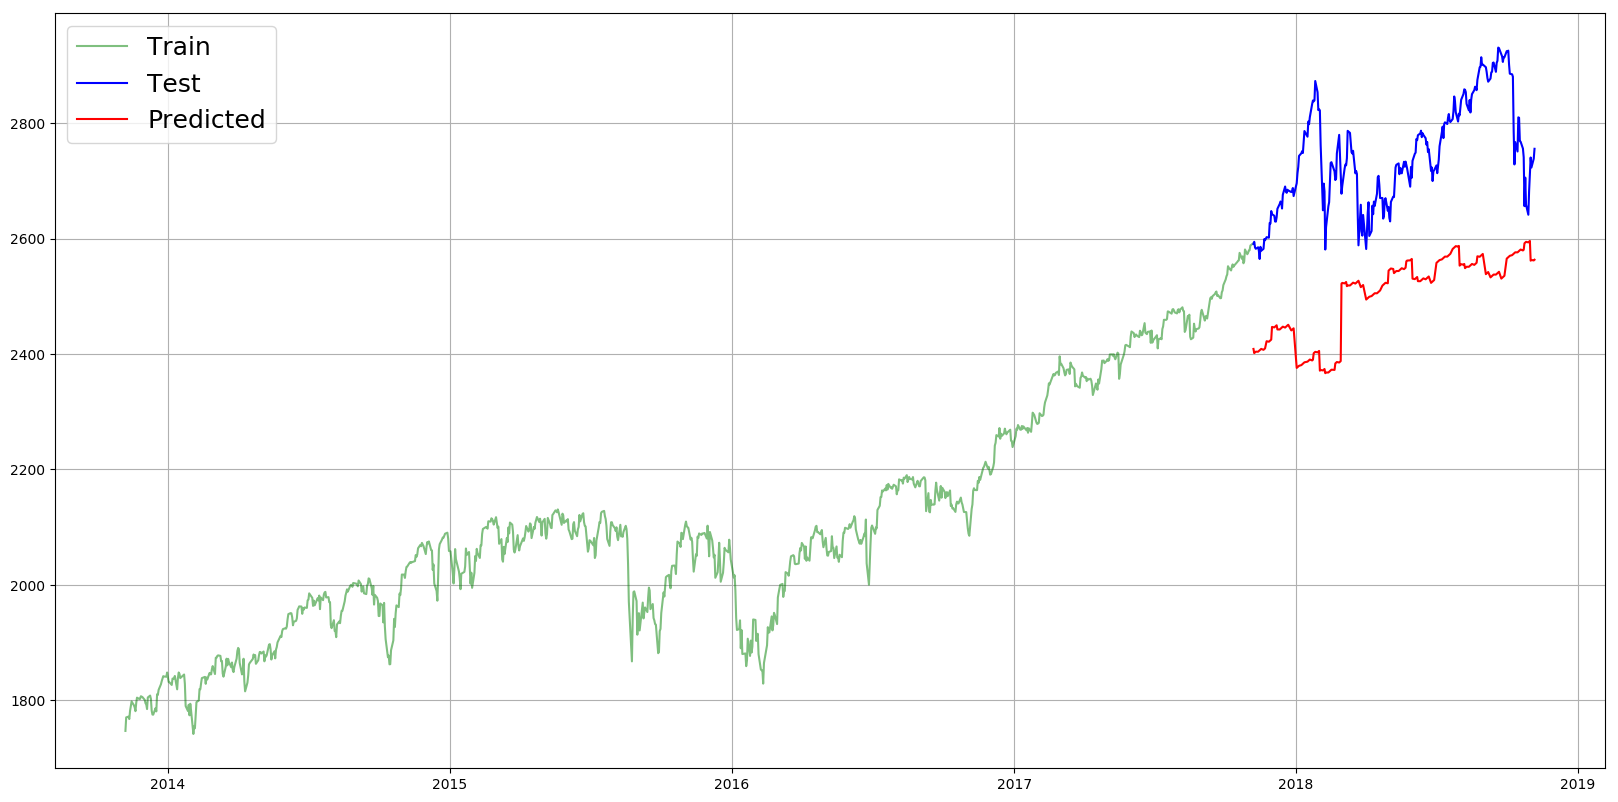

RMSE = 258.70890425066995


In [28]:
plot_preds(train, test)

In [29]:
model.coef_

array([ 1.55089949e+02,  1.70580406e+03,  6.39672008e-01,  5.61168445e+01,
       -5.55374169e+01,  8.41441210e+00,  9.98474572e+00, -1.04014933e+01,
       -2.02111552e+01,  7.58945218e-01])

In [30]:
X_train.columns

Index(['year', 'month', 'dayofweek', 'dayofmonth', 'dayofyear',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'is_option_ex_week'],
      dtype='object')

## Inference
Linear Regression model resulted in higher rmse than moving average. This is because LR overfits to month and year column.  Though and easy to interpret model, it is nowhere close to being useful.

# K Nearest Neighbors

In [31]:
# Importing Libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler(feature_range=(0,1))

In [33]:
#Use the same train and test data from previous section
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [34]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}

In [35]:
# define the model and use it in GridSearchCV
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

In [36]:
#fit the model and make predictions
model.fit(X_train_scaled, y_train)
test['pred'] = model.predict(X_test_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


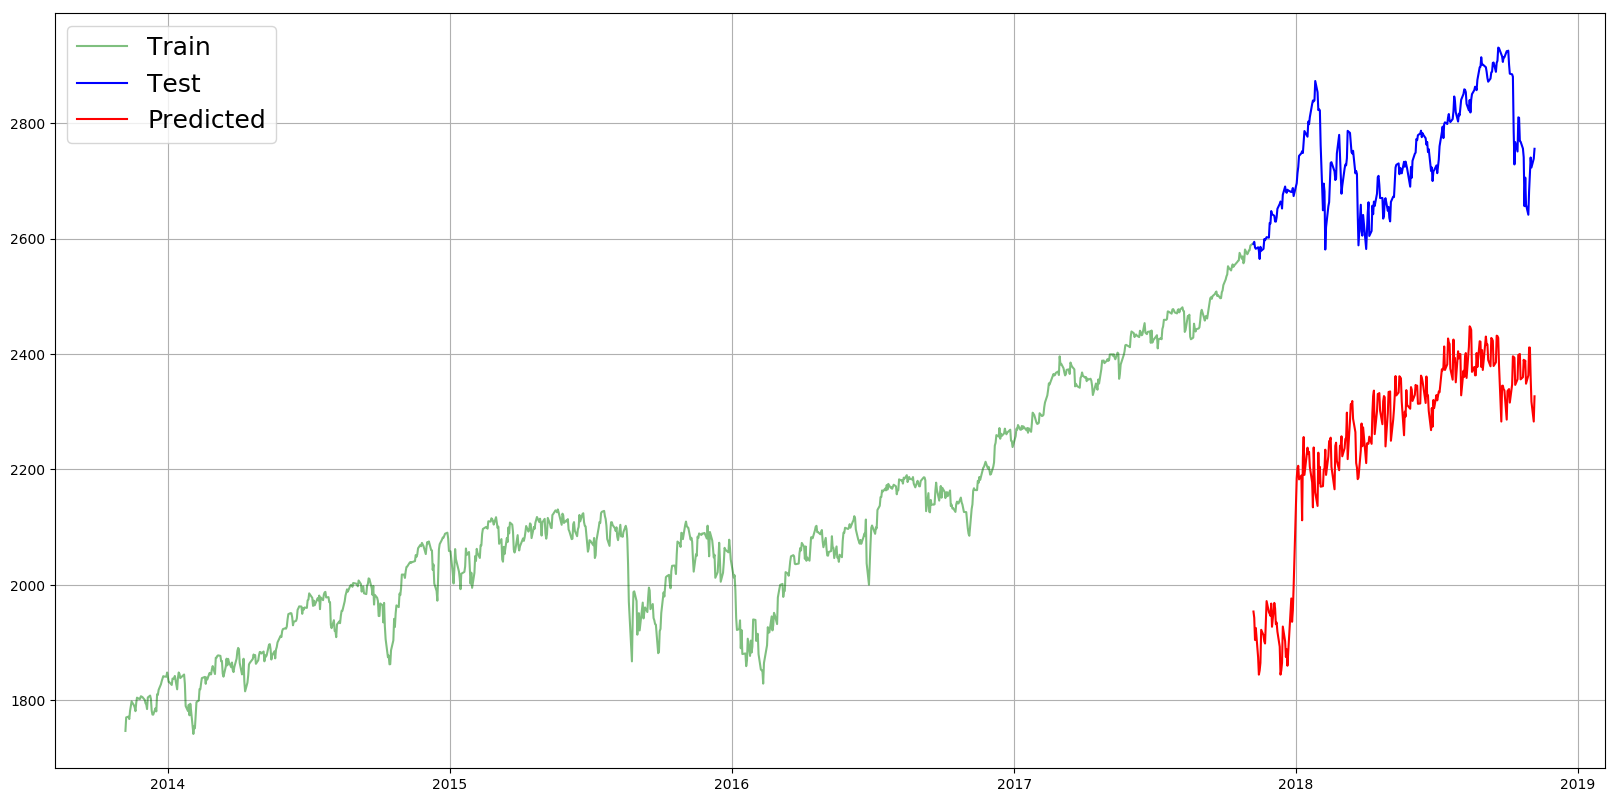

RMSE = 504.60829492718347


In [37]:
plot_preds(train, test)

In [38]:
model.best_params_

{'n_neighbors': 9}

## Inference
rmse is almost twice as the linear model and the results are not useful.  It becomes more and more evident that we need an algorithm that is specialized for time series that can give more weightage for past values,  and also compensate for past errors.  This leads us to ARIMA.  Since ARIMA tuning takes a long time, we will choose Auto ARIMA which selects the best combination of parameters that will result in the minimum error.


## Auto ARIMA
ARIMA (AutoRegresive Integrated Moving Average) is one of the most common algorithm use for predicting time series data. It consists of 3 parameters: p (gives weight to past date), d (affects the amount of differencing to apply to a time series) and q (gives weight to moving average).  Auto ARIMA determines the best combination of p,d,q.

ARIMA is typically applied to time series data that does not have external influence and may not be suited to stock market prediction.  Stock market involves a lot of external factors that affects its performance.  Nevertheless, lets use ARIMA to investigate to get insights into the influence of time on stock market performance

In [39]:
# For ARIMA, we will use only the column 'Close' to create our training and test set
train, test, X_train, y_train, X_test, y_test = create_train_test(spx[['Close']], 0.75)

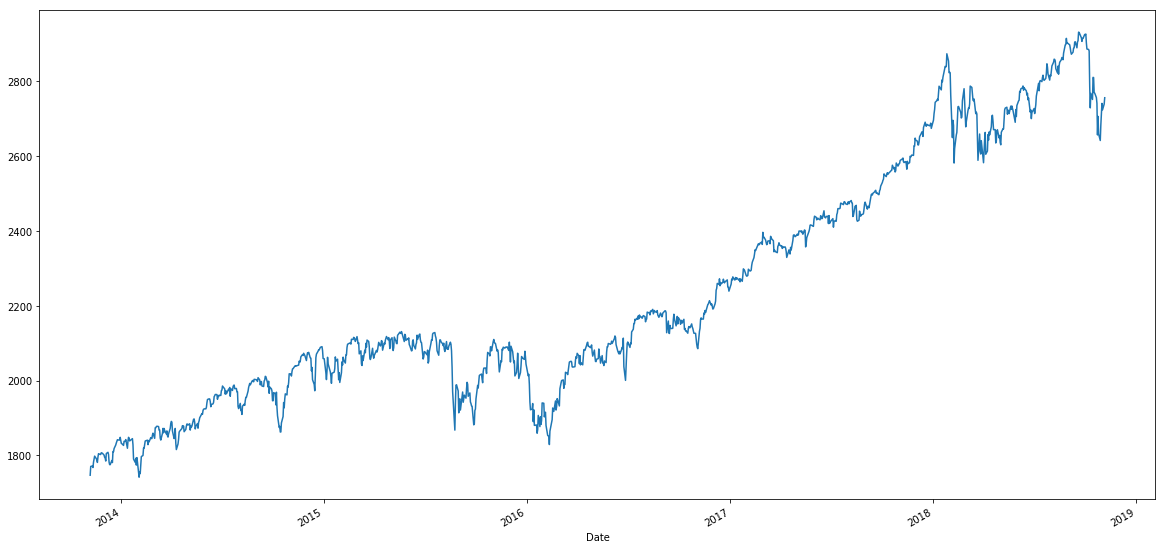

In [40]:
# Lets plot the closing prices to spot available trends
spx['Close'].plot()
plt.show()

# Decomposition
We see an upward trend up to mid 2015 and then a sideway movement up to early 2016 (with some oscillation) and the a strong upward trend. We can use statsmodels to perform a decomposition of this time series.  Decomposition is a task that deconstructs a time series into trend, cyclical, seasonal and irregular component.

We can use an additive model whenn trend is more linear and seasonality & trend components seem to be constant over time.  Multiplicative model should be applied when the trend is non-linear.

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [42]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-11-07 to 2018-11-06
Data columns (total 11 columns):
Close                1259 non-null float64
year                 1259 non-null int32
month                1259 non-null int32
dayofweek            1259 non-null int32
dayofmonth           1259 non-null int32
dayofyear            1259 non-null int32
is_month_start       1259 non-null int32
is_month_end         1259 non-null int32
is_quarter_start     1259 non-null int32
is_quarter_end       1259 non-null int32
is_option_ex_week    1259 non-null int32
dtypes: float64(1), int32(10)
memory usage: 68.9 KB


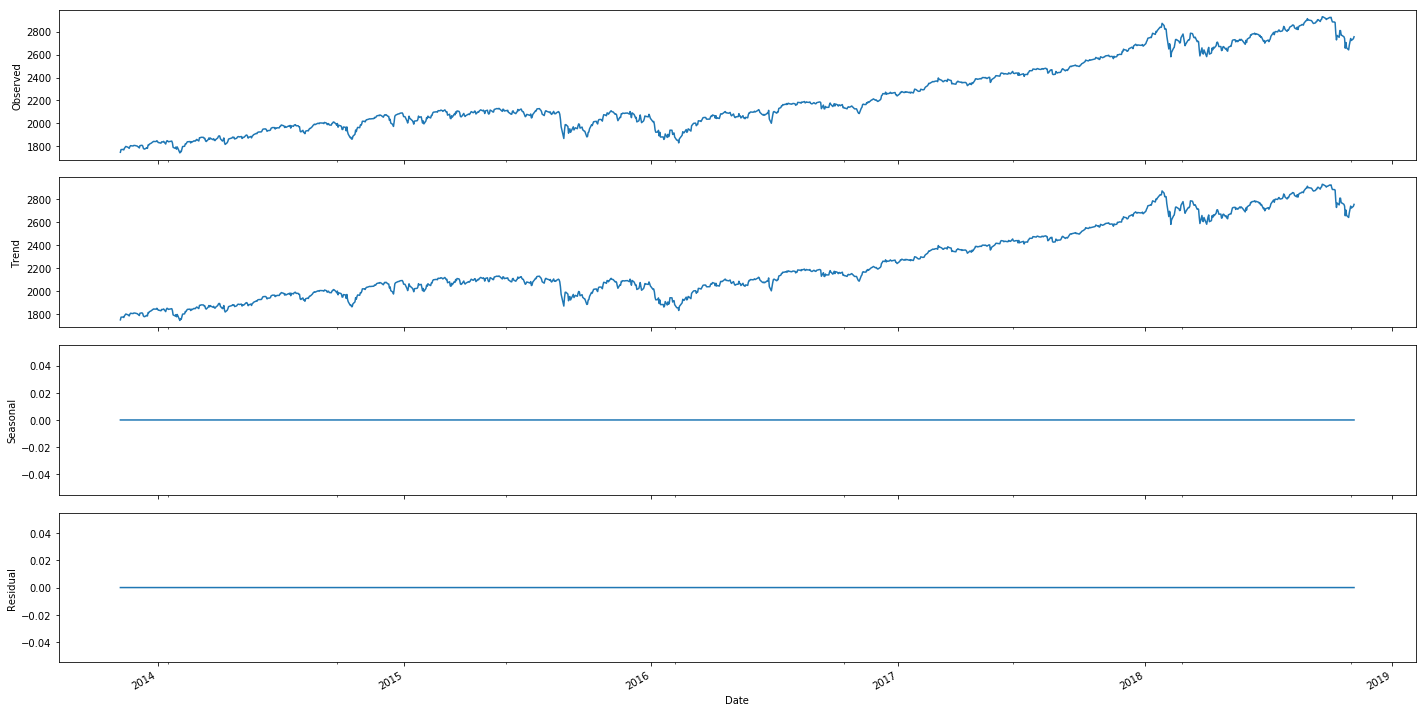

In [43]:
result_additive = seasonal_decompose(spx[['Close']], model='additive', freq=1)
result_additive.plot()
plt.show()

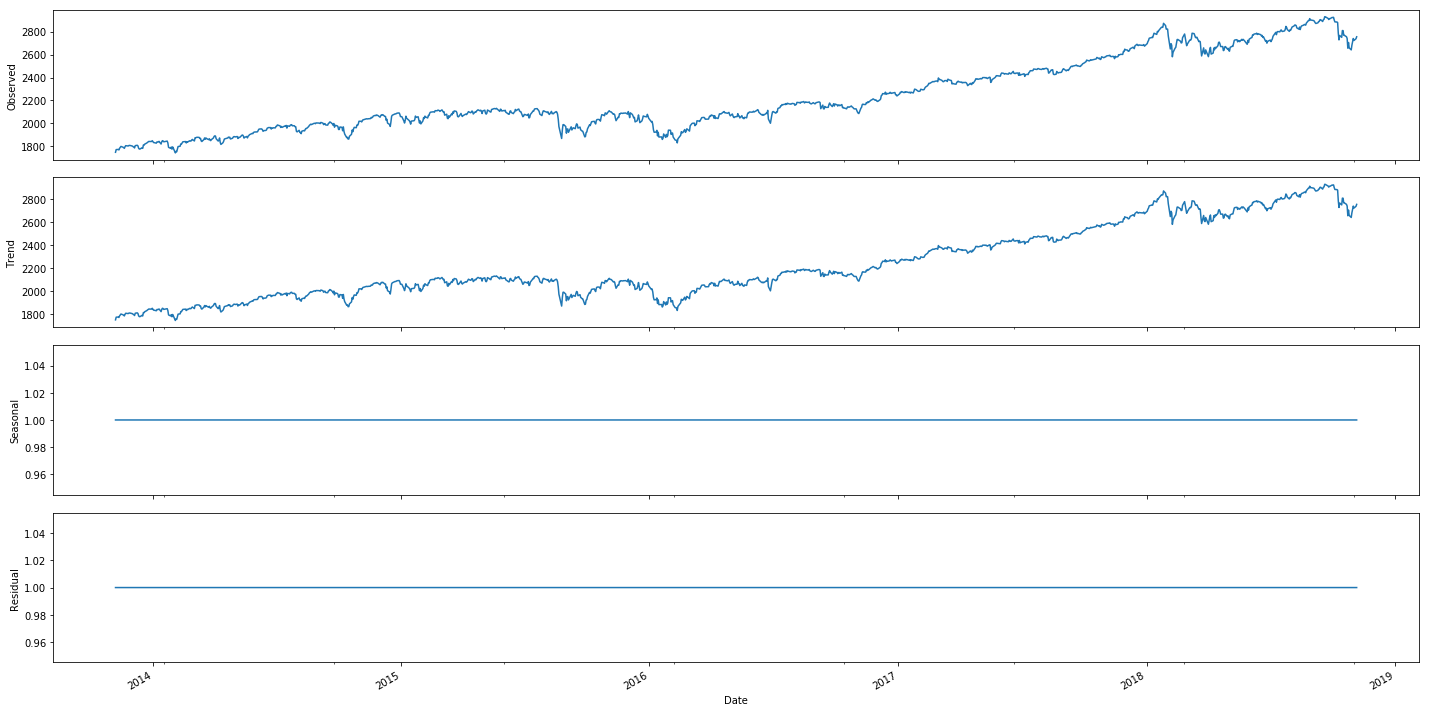

In [44]:
result_multiplicative = seasonal_decompose(spx['Close'], model='multiplicative', freq=1)
result_multiplicative.plot()
plt.show()

It appears like the time series only has a trend component.  Seasonal and Residual component is zero.  

In [45]:
from statsmodels.tsa.arima_model import ARIMA

In [46]:
from pyramid.arima import auto_arima

C:\ProgramData\Anaconda3\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [47]:
split_length = int(spx.shape[0] * 0.8)
train = spx[['Close']][:split_length]
test = spx[['Close']][split_length:]

In [48]:
model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, sasonal=False, d=1, D=1, trace=True, error_action='ignore', surpress_warnings=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=8327.417, BIC=8351.926, Fit time=4.906 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=8958.817, BIC=8968.621, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=8646.044, BIC=8665.651, Fit time=0.994 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=8331.692, BIC=8351.299, Fit time=1.150 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=8328.805, BIC=8358.216, Fit time=7.407 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=8961.969, BIC=8981.576, Fit time=0.423 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=8328.893, BIC=8358.303, Fit time=9.930 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=8329.945, BIC=8364.257, Fit time=13.857 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_ord

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=8330.971, BIC=8365.283, Fit time=6.014 seconds
Total fit time: 50.088 seconds


In [49]:
model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend='c')

In [50]:
test['pred'] = model.predict(n_periods=test.shape[0])

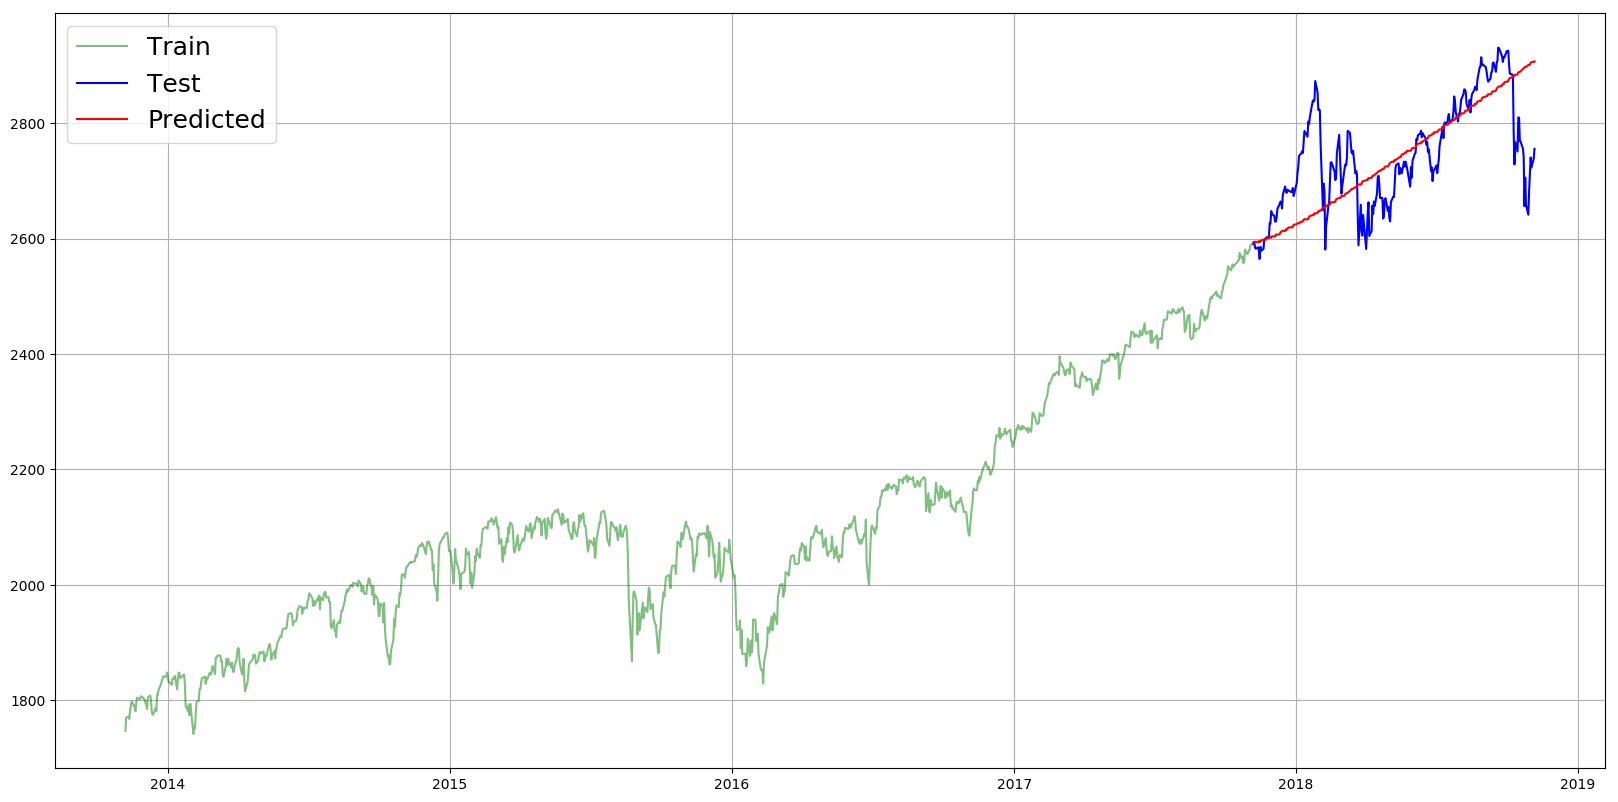

RMSE = 79.77076903098875


In [51]:
plot_preds(train, test)

# Inference
Auto ARIMA used past data and predicted an uptrend in the series.  The predictions are far better than the Moving Average, Linear Regression, and KNN methods.  It has the lowest rmse thus far, but is nevertheless not close enough to the real values to be useful.  Just like the decomposition graph showed, the model predicts the trend well, but does not account for seasonality.


## Prophet
Prophet is a timeseries forecasting library developed by Facebook.  It is simple to implement.  The input to Prophet is a dataframe with two columns: date and target.
Prophet captures the seasonality in past data and works well when there are large number of observations.

In [53]:
#import prophet
from fbprophet import Prophet

In [92]:
#create train and test dataframes
split_length = int(spx.shape[0] * 0.8)
train = spx.iloc[:split_length][['Close']]
train['ds'] = spx.iloc[:split_length].index
train.rename(columns={'Close':'y'}, inplace=True)

test = spx.iloc[split_length:][['Close']]
test['ds'] = spx.iloc[split_length:].index
test.rename(columns={'Close':'y'}, inplace=True)

In [93]:
train.head()

,y,ds
Date,,
2013-11-07,1747.150024,2013-11-07
2013-11-08,1770.609985,2013-11-08
2013-11-11,1771.890015,2013-11-11
2013-11-12,1767.689941,2013-11-12
2013-11-13,1782.000000,2013-11-13


In [94]:
# fit the model
model = Prophet()
model.fit(train)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [104]:
close_prices = model.make_future_dataframe(periods=test.shape[0])
forecast = model.predict(close_prices)
test['pred'] = forecast.iloc[split_length:]['yhat'].values

In [106]:
train['Close'] = train['y']
test['Close'] = test['y']

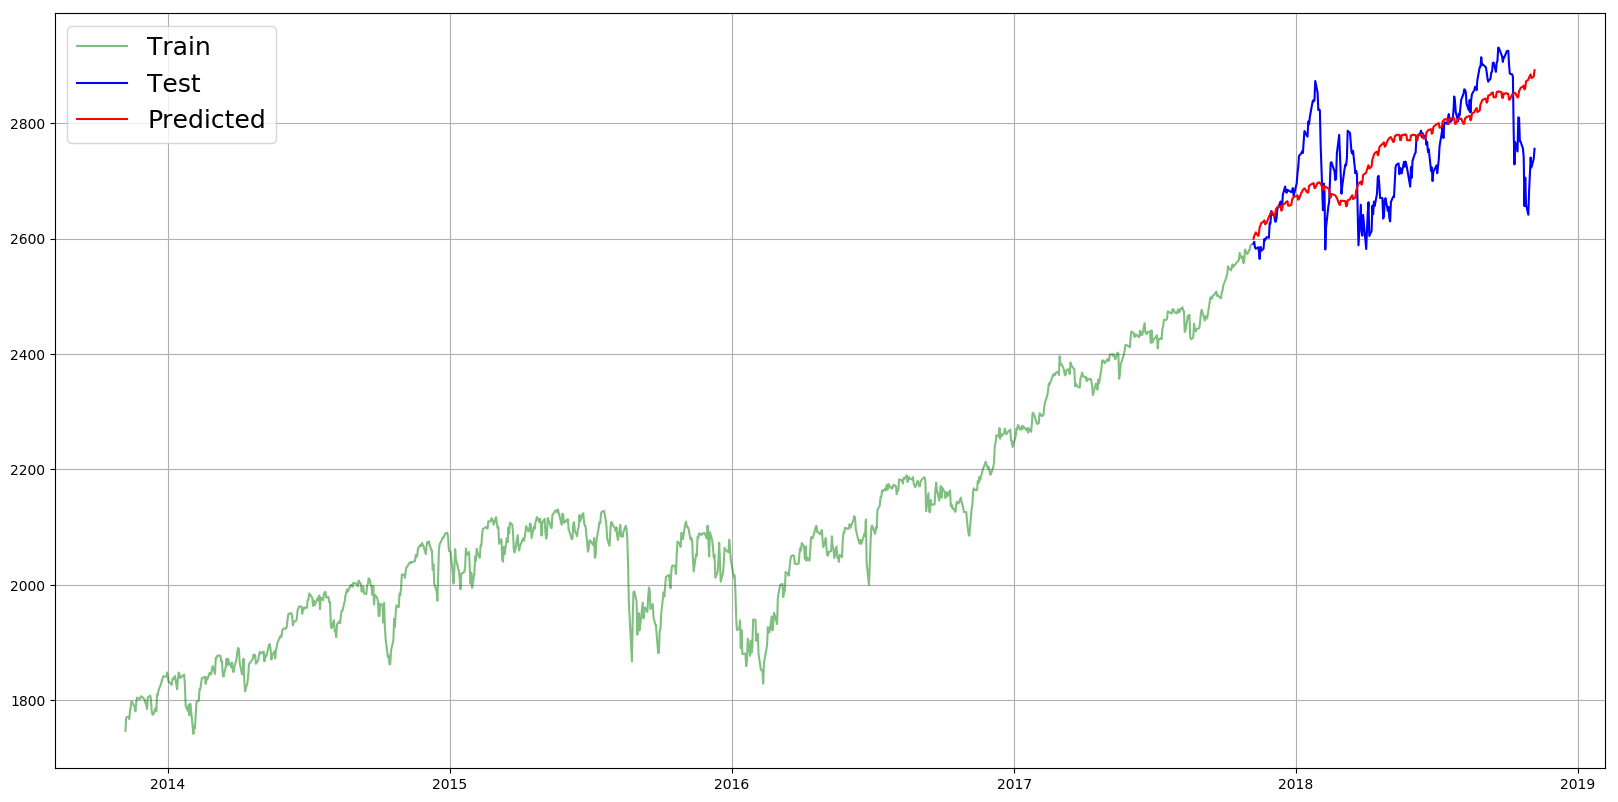

RMSE = 74.43001780195618


In [107]:
plot_preds(train, test)

Prophet, like other time series forecasting models, captures trend and seasonality from historical data.  It resulted in a better rmse than other models so far, but does not quite live up to the lofty expectations.
Since stock prices switches from trend and seasonality all the time and since there 